In [1]:
%%capture --no-stdout
import os
from scipy.stats import ks_2samp

from utils import *
from preprocessing import *
from models import *
import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
%%capture --no-stdout
#df = load_frame_for_prediction('wilmington')
df = load_frame_for_prediction('reno')
#df = load_frame_for_prediction('littlerock')

Could not find preprocessed data.
Starting preprocessing ...
Imputing missing values with zeros
23280 missing values imputted (48.71%)
Removing rows with negative costs
Encoding categorical features
Model_frame saved here : prep_data/model_frame/reno
Loading data...
Data loaded


In [3]:
df_1 = df[df.wo_category==1].drop('wo_category', axis=1)
df_2 = df[df.wo_category==2].drop('wo_category', axis=1)
df_3 = df[df.wo_category==3].drop('wo_category', axis=1)
df_4 = df[df.wo_category==4].drop('wo_category', axis=1)

# Removing outliers using Quantiles

I drop rows:
- when revenue or expected revenue is 0
- when cost or estimate cost is very low (lowest 3%)
- when cost, estimate cost or work arising cost are high with the 2*IQR rule
- when revenue, estimate revenue or work arising revenue are high with the 2*IQR rule

In [4]:
clean = remove_outliers(df)

Outliers represents 28.5% of the dataset
Outliers represents 36.5% of the dataset
Outliers represents 19.6% of the dataset
Outliers represents 19.4% of the dataset


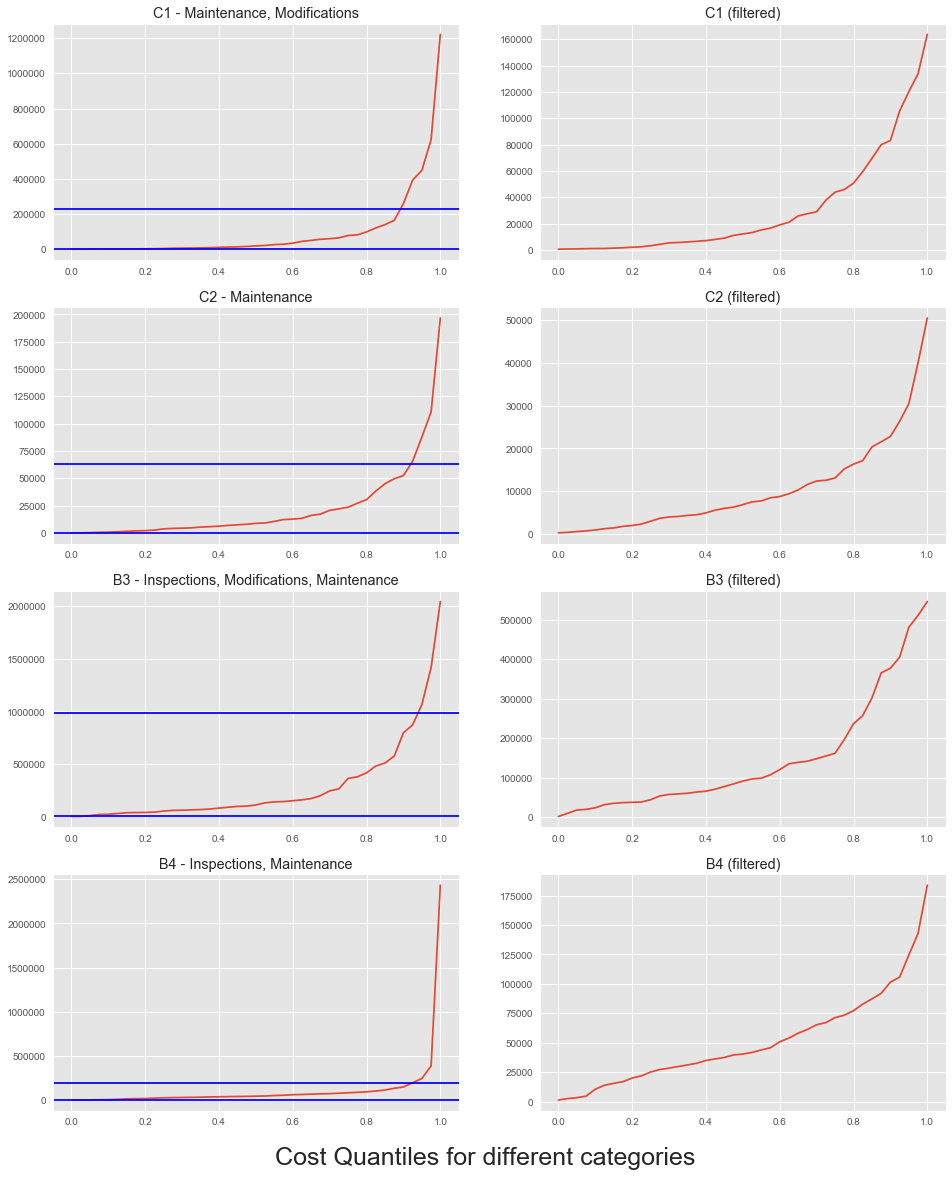

In [5]:
# Four axes, returned as a 2-d array
fig, axarr = plt.subplots(4, 2, figsize=(16,20))

# C-1
axarr[0, 0].plot(np.linspace(0,1,41), df_1.TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[0, 0].axhline(get_iqr_bound(df_1.TOTALSQUAWKCOST), color='b')
axarr[0, 0].axhline(df_1.TOTALSQUAWKCOST.quantile(0.03), color='b')
axarr[0, 0].set_title('C1 - Maintenance, Modifications')

axarr[0, 1].plot(np.linspace(0,1,41), clean[0].TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[0, 1].set_title('C1 (filtered)')

# C-2
axarr[1, 0].plot(np.linspace(0,1,41), df_2.TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[1, 0].axhline(get_iqr_bound(df_2.TOTALSQUAWKCOST), color='b')
axarr[1, 0].axhline(df_2.TOTALSQUAWKCOST.quantile(0.03), color='b')
axarr[1, 0].set_title('C2 - Maintenance')

axarr[1, 1].plot(np.linspace(0,1,41), clean[1].TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[1, 1].set_title('C2 (filtered)')

# B-3
axarr[2, 0].plot(np.linspace(0,1,41), df_3.TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[2, 0].axhline(get_iqr_bound(df_3.TOTALSQUAWKCOST), color='b')
axarr[2, 0].axhline(df_3.TOTALSQUAWKCOST.quantile(0.03), color='b')
axarr[2, 0].set_title('B3 - Inspections, Modifications, Maintenance')

axarr[2, 1].plot(np.linspace(0,1,41), clean[2].TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[2, 1].set_title('B3 (filtered)')

# B-4
axarr[3, 0].plot(np.linspace(0,1,41), df_4.TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[3, 0].axhline(get_iqr_bound(df_4.TOTALSQUAWKCOST), color='b')
axarr[3, 0].axhline(df_4.TOTALSQUAWKCOST.quantile(0.03), color='b')
axarr[3, 0].set_title('B4 - Inspections, Maintenance')

axarr[3, 1].plot(np.linspace(0,1,41), clean[3].TOTALSQUAWKCOST.quantile(np.linspace(0,1,41)))
axarr[3, 1].set_title('B4 (filtered)')

fig.suptitle('Cost Quantiles for different categories', fontsize=25, y=0.1)
fig.show()

# Models

### Metric = w-MAPE

In [6]:
feat_1, cost_1, wa_cost_1, wa_est_cost_1 = prep_data_for_modelisation(clean[0])

### Baseline : Dassault Estimates

In [7]:
print(w_mape(y_pred=feat_1.TOTALSQUAWKESTIMATEDCOST, y_true=cost_1))
print(w_mape(y_pred=wa_est_cost_1, y_true=wa_cost_1))


28.669996512493903
67.87235619598604


In [8]:
# Lasso Model
warnings.filterwarnings('ignore')
pg = {'alpha' : np.round(np.logspace(start=0, stop = 5, num = 20), 4)}
gs = cross_validate_model(data=feat_1,target=cost_1,
                     model='lasso', param_grid=pg, scale=True)

# Ridge Model
pg = {'alpha' : np.round(np.logspace(start=-2, stop = 5, num = 20), 4)}
gs = cross_validate_model(data=feat_1,target=cost_1,
                     model='ridge', param_grid=pg, scale=True)

############# lasso ################
Best parameters : {'alpha': 784.76}
Scores 
Train: -19.313854913672948 % (+/- 3.6783448652195583)
Test: -41.814108004904334 % (+/- 30.163200905410065)

############# ridge ################
Best parameters : {'alpha': 20.6914}
Scores 
Train: -19.361065068766827 % (+/- 3.824100314357993)
Test: -38.62932389697955 % (+/- 22.907047130741468)



# Feature importances & selection

I drop features where more than 80% of values are 0.

I then select the 20 best with Lasso (or less if less than 20 features has non null coefficients)

In [9]:
best_feat_1 = feat_1[select_lasso_k_best(feat_1, cost_1)]

In [10]:
# Lasso Model
warnings.filterwarnings('ignore')
pg = {'alpha' : np.round(np.logspace(start=0, stop = 2, num = 20), 4)}
gs = cross_validate_model(data=best_feat_1,target=cost_1,
                     model='lasso', param_grid=pg, scale=True)

# Ridge Model
pg = {'alpha' : np.round(np.logspace(start=-2, stop = 2, num = 20), 4)}
gs = cross_validate_model(data=best_feat_1,target=cost_1,
                     model='ridge', param_grid=pg, scale=True)

############# lasso ################
Best parameters : {'alpha': 37.9269}
Scores 
Train: -16.136318820908905 % (+/- 1.816284450852738)
Test: -36.49366003957224 % (+/- 29.613763117327217)

############# ridge ################
Best parameters : {'alpha': 1.2743}
Scores 
Train: -17.566952946139402 % (+/- 2.4439250114360163)
Test: -37.943921793955894 % (+/- 32.37821731782352)



# Results

In [11]:
scores=[]
wa_scores=[]
for data,name in zip(clean, ['C1', 'C2', 'B3', 'B4']):
    s,ws = get_result(data)
    scores.append(pd.Series(s, name=name))
    wa_scores.append(pd.Series(ws, name=name))

In [12]:
cost_results = pd.concat(scores,axis=1).abs()
wa_cost_results = pd.concat(wa_scores,axis=1).abs()

In [13]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [14]:
cost_results.style.apply(highlight_min)

,C1,C2,B3,B4
cost_baseline,28.67,50.8474,25.334,21.5174
Lasso,42.1477,48.1711,22.1611,20.4478
Lasso with feature selection,36.6534,36.9986,21.9738,19.6687
Ridge,38.6293,50.0054,34.4606,21.5419
Ridge with feature selection,37.921,36.3759,25.2328,19.5245


In [15]:
wa_cost_results.style.apply(highlight_min)

,C1,C2,B3,B4
cost_baseline,67.8724,85.6203,49.7681,745.243
Lasso,206.064,135.8,66.7291,73.1975
Lasso with feature selection,205.226,127.132,65.7483,71.6384
Ridge,207.27,143.133,79.3883,74.5479
Ridge with feature selection,189.069,125.296,67.6612,72.3409


In [16]:
os.makedirs('scores', exist_ok=True)
cost_results.to_csv(os.path.join('scores','cost_results_reno.csv'))
wa_cost_results.to_csv(os.path.join('scores','wa_cost_results_reno.csv'))